In [60]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import linregress
from scipy.stats import linregress, ttest_ind
from sklearn.model_selection import train_test_split
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor

In [4]:
File1 = pd.read_csv("/content/File1.csv")
File2 = pd.read_csv("/content/File2.csv")
File3 = pd.read_csv("/content/File3.csv")


In [5]:
df = pd.concat([File1, File2, File3], axis=0, ignore_index=True)

In [6]:
print("Total records:", df.shape[0])
df.head()

Total records: 1006029


,date,state,district,pincode,age_0_5,age_5_17,age_18_greater
0,02-03-2025,Meghalaya,East Khasi Hills,793121,11,61,37
1,09-03-2025,Karnataka,Bengaluru Urban,560043,14,33,39
2,09-03-2025,Uttar Pradesh,Kanpur Nagar,208001,29,82,12
3,09-03-2025,Uttar Pradesh,Aligarh,202133,62,29,15
4,09-03-2025,Karnataka,Bengaluru Urban,560016,14,16,21


In [7]:
df.columns = df.columns.str.lower().str.replace(" ", "_")

In [8]:
for col in df.select_dtypes(include=['int64', 'float64']).columns:
    df[col].fillna(df[col].median(), inplace=True)

for col in df.select_dtypes(include=['object']).columns:
    df[col].fillna(df[col].mode()[0], inplace=True)

/tmp/ipython-input-1618090723.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[col].fillna(df[col].median(), inplace=True)
/tmp/ipython-input-1618090723.py:5: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try usin

In [9]:
df.drop_duplicates(inplace=True)

In [11]:
df['date'] = pd.to_datetime(df['date'], dayfirst=True)
print("Data cleaning completed")

Data cleaning completed


In [12]:
df['year'] = df['date'].dt.year
df['month'] = df['date'].dt.month

In [18]:
df['total_aadhaar'] = (
    df['age_0_5'] +
    df['age_5_17'] +
    df['age_18_greater']
)

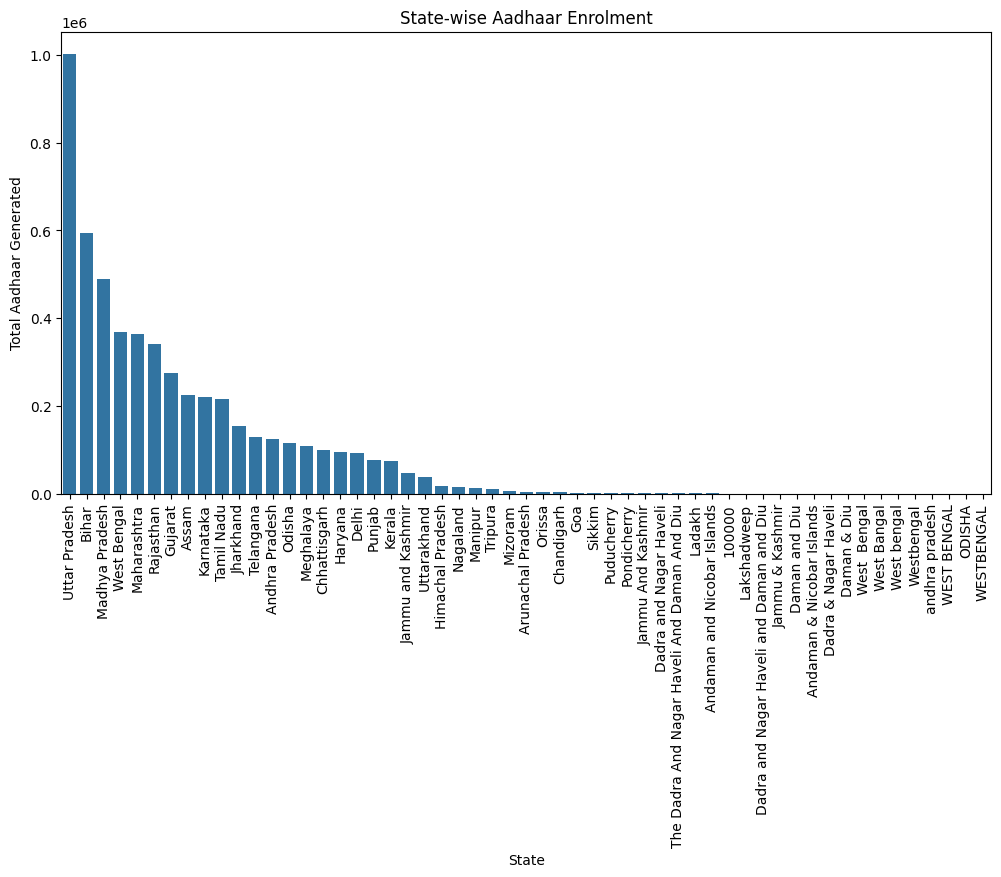

In [20]:
state_summary = df.groupby('state')['total_aadhaar'].sum().reset_index()

plt.figure(figsize=(12,6))
sns.barplot(
    data=state_summary.sort_values('total_aadhaar', ascending=False),
    x='state', y='total_aadhaar'
)
plt.xticks(rotation=90)
plt.title("State-wise Aadhaar Enrolment")
plt.xlabel("State")
plt.ylabel("Total Aadhaar Generated")
plt.show()

In [21]:
age_totals = df[['age_0_5','age_5_17','age_18_greater']].sum()

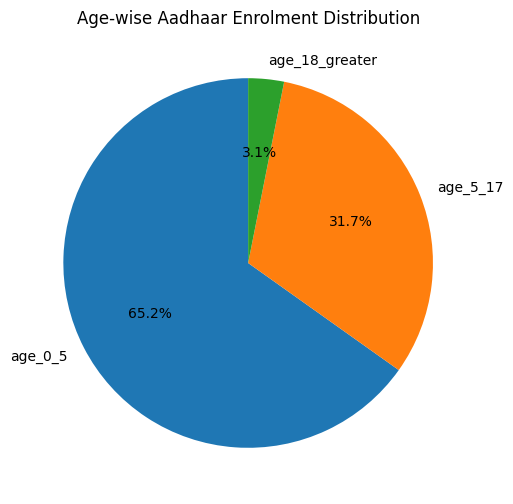

In [22]:
plt.figure(figsize=(6,6))
plt.pie(
    age_totals,
    labels=age_totals.index,
    autopct='%1.1f%%',
    startangle=90
)
plt.title("Age-wise Aadhaar Enrolment Distribution")
plt.show()

In [30]:
state_totals = df.groupby('state')['total_aadhaar'].sum().reset_index()

In [31]:
top_5 = state_totals.sort_values('total_aadhaar', ascending=False).head(5)
bottom_5 = state_totals.sort_values('total_aadhaar').head(5)

In [32]:
comparison_states = pd.concat([top_5, bottom_5])

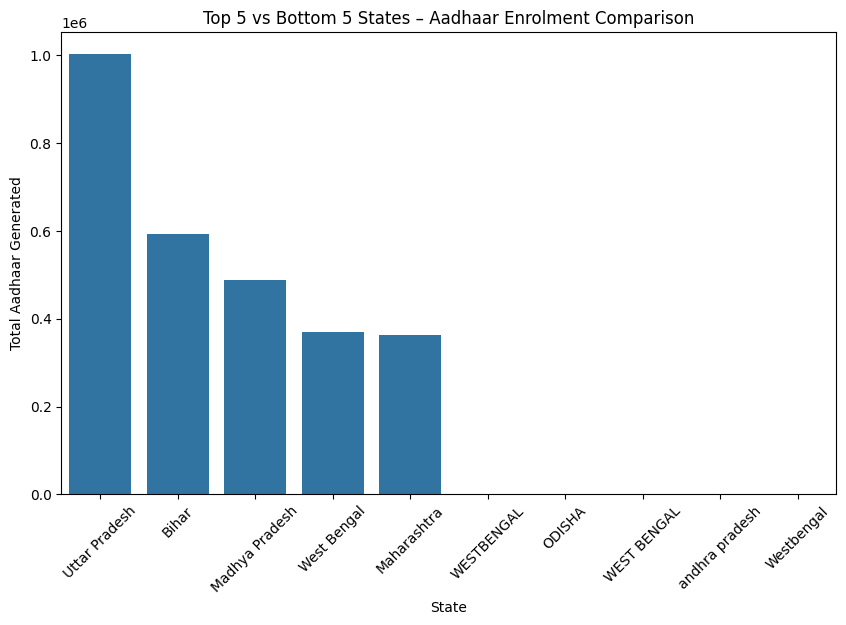

In [33]:
plt.figure(figsize=(10,6))
sns.barplot(
    data=comparison_states,
    x='state', y='total_aadhaar'
)
plt.xticks(rotation=45)
plt.title("Top 5 vs Bottom 5 States – Aadhaar Enrolment Comparison")
plt.xlabel("State")
plt.ylabel("Total Aadhaar Generated")
plt.show()

In [35]:
recent_years = df['year'].max() - 2

In [36]:
recent_avg = df[df['year'] >= recent_years]['total_aadhaar'].mean()
historical_avg = df['total_aadhaar'].mean()

In [37]:
momentum_df = pd.DataFrame({
    'Period': ['Historical Average', 'Recent Years Average'],
    'Average Enrolment': [historical_avg, recent_avg]
})

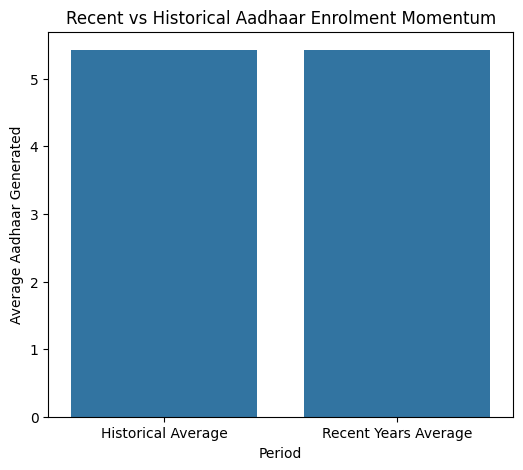

In [38]:
plt.figure(figsize=(6,5))
sns.barplot(
    data=momentum_df,
    x='Period', y='Average Enrolment'
)
plt.title("Recent vs Historical Aadhaar Enrolment Momentum")
plt.ylabel("Average Aadhaar Generated")
plt.show()

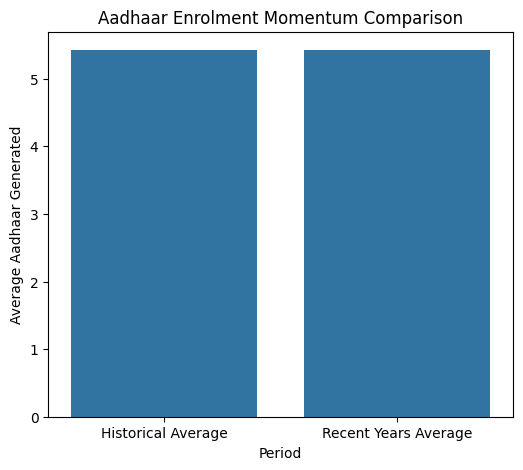

In [53]:
model = ARIMA(yearly['total_aadhaar'], order=(1,1,1))
model_fit = model.fit()

forecast = model_fit.forecast(steps=3)
print("Next 3 Years Forecast:")
print(forecast)


Next 3 Years Forecast:
1    5331760.0
2    5331760.0
3    5331760.0
Name: predicted_mean, dtype: float64


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for ARMA and trend. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/statespace/mlemodel.py:1235: RuntimeWarning: invalid value encountered in divide
  np.inner(score_obs, score_obs) /


In [56]:
X = df[['year', 'age_0_5', 'age_5_17', 'age_18_greater']]
y = df['total_aadhaar']

In [61]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

In [62]:
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)

y_pred_lr = lr_model.predict(X_test)

lr_rmse = np.sqrt(mean_squared_error(y_test, y_pred_lr))
lr_r2 = r2_score(y_test, y_pred_lr)

print("Linear Regression RMSE:", lr_rmse)
print("Linear Regression R²:", lr_r2)


Linear Regression RMSE: 4.7347170912383156e-14
Linear Regression R²: 1.0


In [63]:
rf_model = RandomForestRegressor(
    n_estimators=100,
    max_depth=10,
    random_state=42
)

rf_model.fit(X_train, y_train)
y_pred_rf = rf_model.predict(X_test)

rf_rmse = np.sqrt(mean_squared_error(y_test, y_pred_rf))
rf_r2 = r2_score(y_test, y_pred_rf)

print("Random Forest RMSE:", rf_rmse)
print("Random Forest R²:", rf_r2)


Random Forest RMSE: 2.885472868147277
Random Forest R²: 0.9922631781876501


In [65]:
comparison_df = pd.DataFrame({
    'Model': ['Linear Regression', 'Random Forest'],
    'RMSE': [lr_rmse, rf_rmse],
    'R2_Score': [lr_r2, rf_r2]
})

comparison_df

,Model,RMSE,R2_Score
0,Linear Regression,4.734717e-14,1.000000
1,Random Forest,2.885473e+00,0.992263


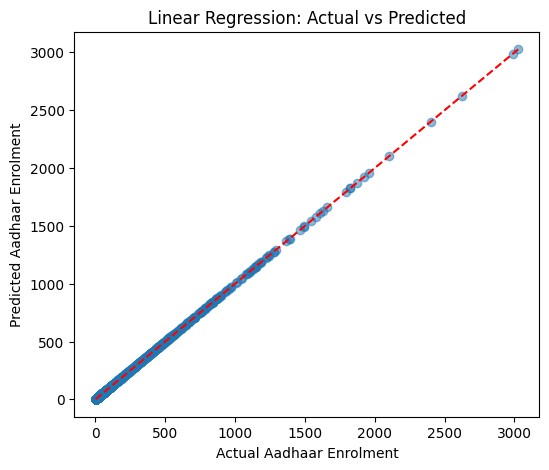

In [66]:
plt.figure(figsize=(6,5))
plt.scatter(y_test, y_pred_lr, alpha=0.5)
plt.plot([y_test.min(), y_test.max()],
         [y_test.min(), y_test.max()], 'r--')

plt.title("Linear Regression: Actual vs Predicted")
plt.xlabel("Actual Aadhaar Enrolment")
plt.ylabel("Predicted Aadhaar Enrolment")
plt.show()


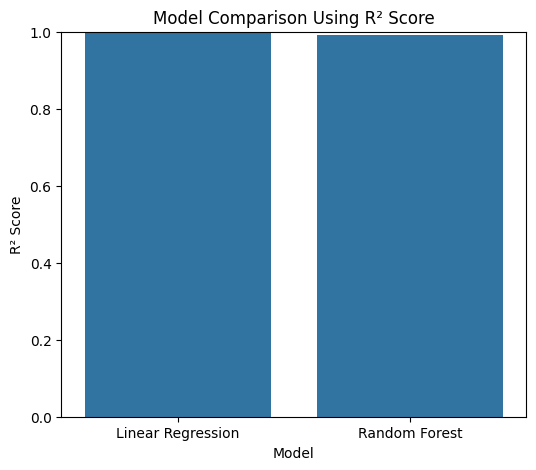

In [67]:
plt.figure(figsize=(6,5))
sns.barplot(
    data=comparison_df,
    x='Model', y='R2_Score'
)
plt.title("Model Comparison Using R² Score")
plt.ylabel("R² Score")
plt.ylim(0,1)
plt.show()
